<a href="https://colab.research.google.com/github/nashyvant/parallel_distributed_prog/blob/main/mandelbrot_in_CUDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi


Fri Nov  8 19:07:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
%%writefile hello.cu

#include<stdio.h>
__global__ void hello(void)
{
    printf("GPU: Hello!\n");
}
int main(int argc,char **argv)
{
    printf("CPU: Hello!\n");
    hello<<<2,10>>>();
    cudaDeviceReset();
    return 0;
}

Writing hello.cu


In [4]:
!nvcc hello.cu -o hello

In [ ]:
!./hello

CPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!


In [25]:

%%writefile mandelbrot.cu
#include <stdio.h>
#include <stdint.h>

#define WIDTH 1280*8
#define HEIGHT 1024*8

//Source : https://forums.developer.nvidia.com/t/maximum-number-of-threads-in-a-gpu/237761
//The NVIDIA Tesla T4 GPU has a maximum of 1024 threads per block:
//NVIDIA Tesla T4 GPU
//Maximum number of threads per block 1024
//Number of CUDA cores 2560
//Total number of registers available per block: 65536
//Warp size:                                     32
//Maximum number of threads per multiprocessor:  1024
//Maximum number of threads per block:           1024
//Max dimension size of a thread block (x,y,z): (1024, 1024, 64)
//Max dimension size of a grid size    (x,y,z): (2147483647, 65535, 65535)
//Hence, number of instantaneous threads which can run in a GPU (ideally) = Number of thread per SM(1024) * Total # of SMs(40) = 40960

// CUDA Kernel for Mandelbrot calculation
__global__ void mandelbrot(uint32_t *counts, uint32_t maxcount, uint32_t w, uint32_t h,
                           float xmin, float xmax, float ymin, float ymax)
{
    int idx = blockIdx.x * blockDim.x + threadIdx.x; //thread ID in x direction; blockDim here is 32
    int idy = blockIdx.y * blockDim.y + threadIdx.y; //thread ID in y direction; blockDim here is 32

    if(idx >= w || idy >= h) //out of bounds
        return;

    // Map pixel coordinates to complex plane coordinates; calculate the complex number for a pixel
    float x = xmin + ((xmax - xmin) * idx) / (w-1);
    float y = ymin + ((ymax - ymin) * idy) / (h-1);

    float real = 0;
    float imag = 0;

    uint32_t count = 0;

    // Mandelbrot iteration
    while (real * real + imag * imag <= 4.0f && count < maxcount) //count until we hit a radius of 2 from the origin; if > 2, point has escaped
    {
        float temp_real = real * real - imag * imag + x;
        imag = 2 * real * imag + y;
        real = temp_real;
        count++;
    }

    // Store the result (number of iterations before escaping)
    counts[idy * w + idx] = count;
}

int main()
{
    uint32_t width = WIDTH ;
    uint32_t height = HEIGHT ;
    uint32_t max_iterations = 256;
    float xmin = -2.0f, xmax = 1.0f, ymin = -1.0f, ymax = 1.0f;

    // Allocate memory for the output (counts array)
    uint32_t *counts = (uint32_t*)malloc(width * height * sizeof(uint32_t));

    // Allocate memory on the device (GPU)
    uint32_t *counts_gpu;
    cudaMalloc((void**)&counts_gpu, width * height * sizeof(uint32_t));

    // Define block size and grid size
    dim3 block_size(32, 32); //each block has 16 threads here in each direction; total of 256 threads in each block; max of 1024 threads per block
    dim3 grid_size((width + block_size.x - 1) / block_size.x,
                   (height + block_size.y - 1) / block_size.y, 1); //getting the grid size, i.e., # of blocks in grid in each direction - 320 x 256 = 81920; 81920*1024 = 83,886,080

    // Launch the kernel
    mandelbrot<<<grid_size, block_size>>>(counts_gpu, max_iterations, width, height, xmin, xmax, ymin, ymax);

    // Wait for GPU to finish, blocks CPU
    cudaDeviceSynchronize();

    // Copy the result back to the host (CPU)
    cudaMemcpy(counts, counts_gpu, width * height * sizeof(uint32_t), cudaMemcpyDeviceToHost);

    // Save the output as an image
    FILE *f = fopen("mandelbrot.raw", "wb");
    if (f)
    {
        fwrite(counts, sizeof(uint32_t), width * height, f);
        fclose(f);
    }

    // Clean up memory
    free(counts);
    cudaFree(counts_gpu);

    return 0;
}


Overwriting mandelbrot.cu


In [28]:
import time
# Compile and run the CUDA program
!nvcc -o mandelbrot mandelbrot.cu  # Compile the CUDA code
start_time = time.time()
for i in range(2):
  #print("Mandelbrot iteration ", i)
  !./mandelbrot  # Run the compiled CUDA program
end_time = time.time()
compute_time = (end_time - start_time)/40
print("Total time taken to compute Mandelbrot: {:.2f} seconds".format(compute_time))

Total time taken to compute Mandelbrot: 0.06 seconds


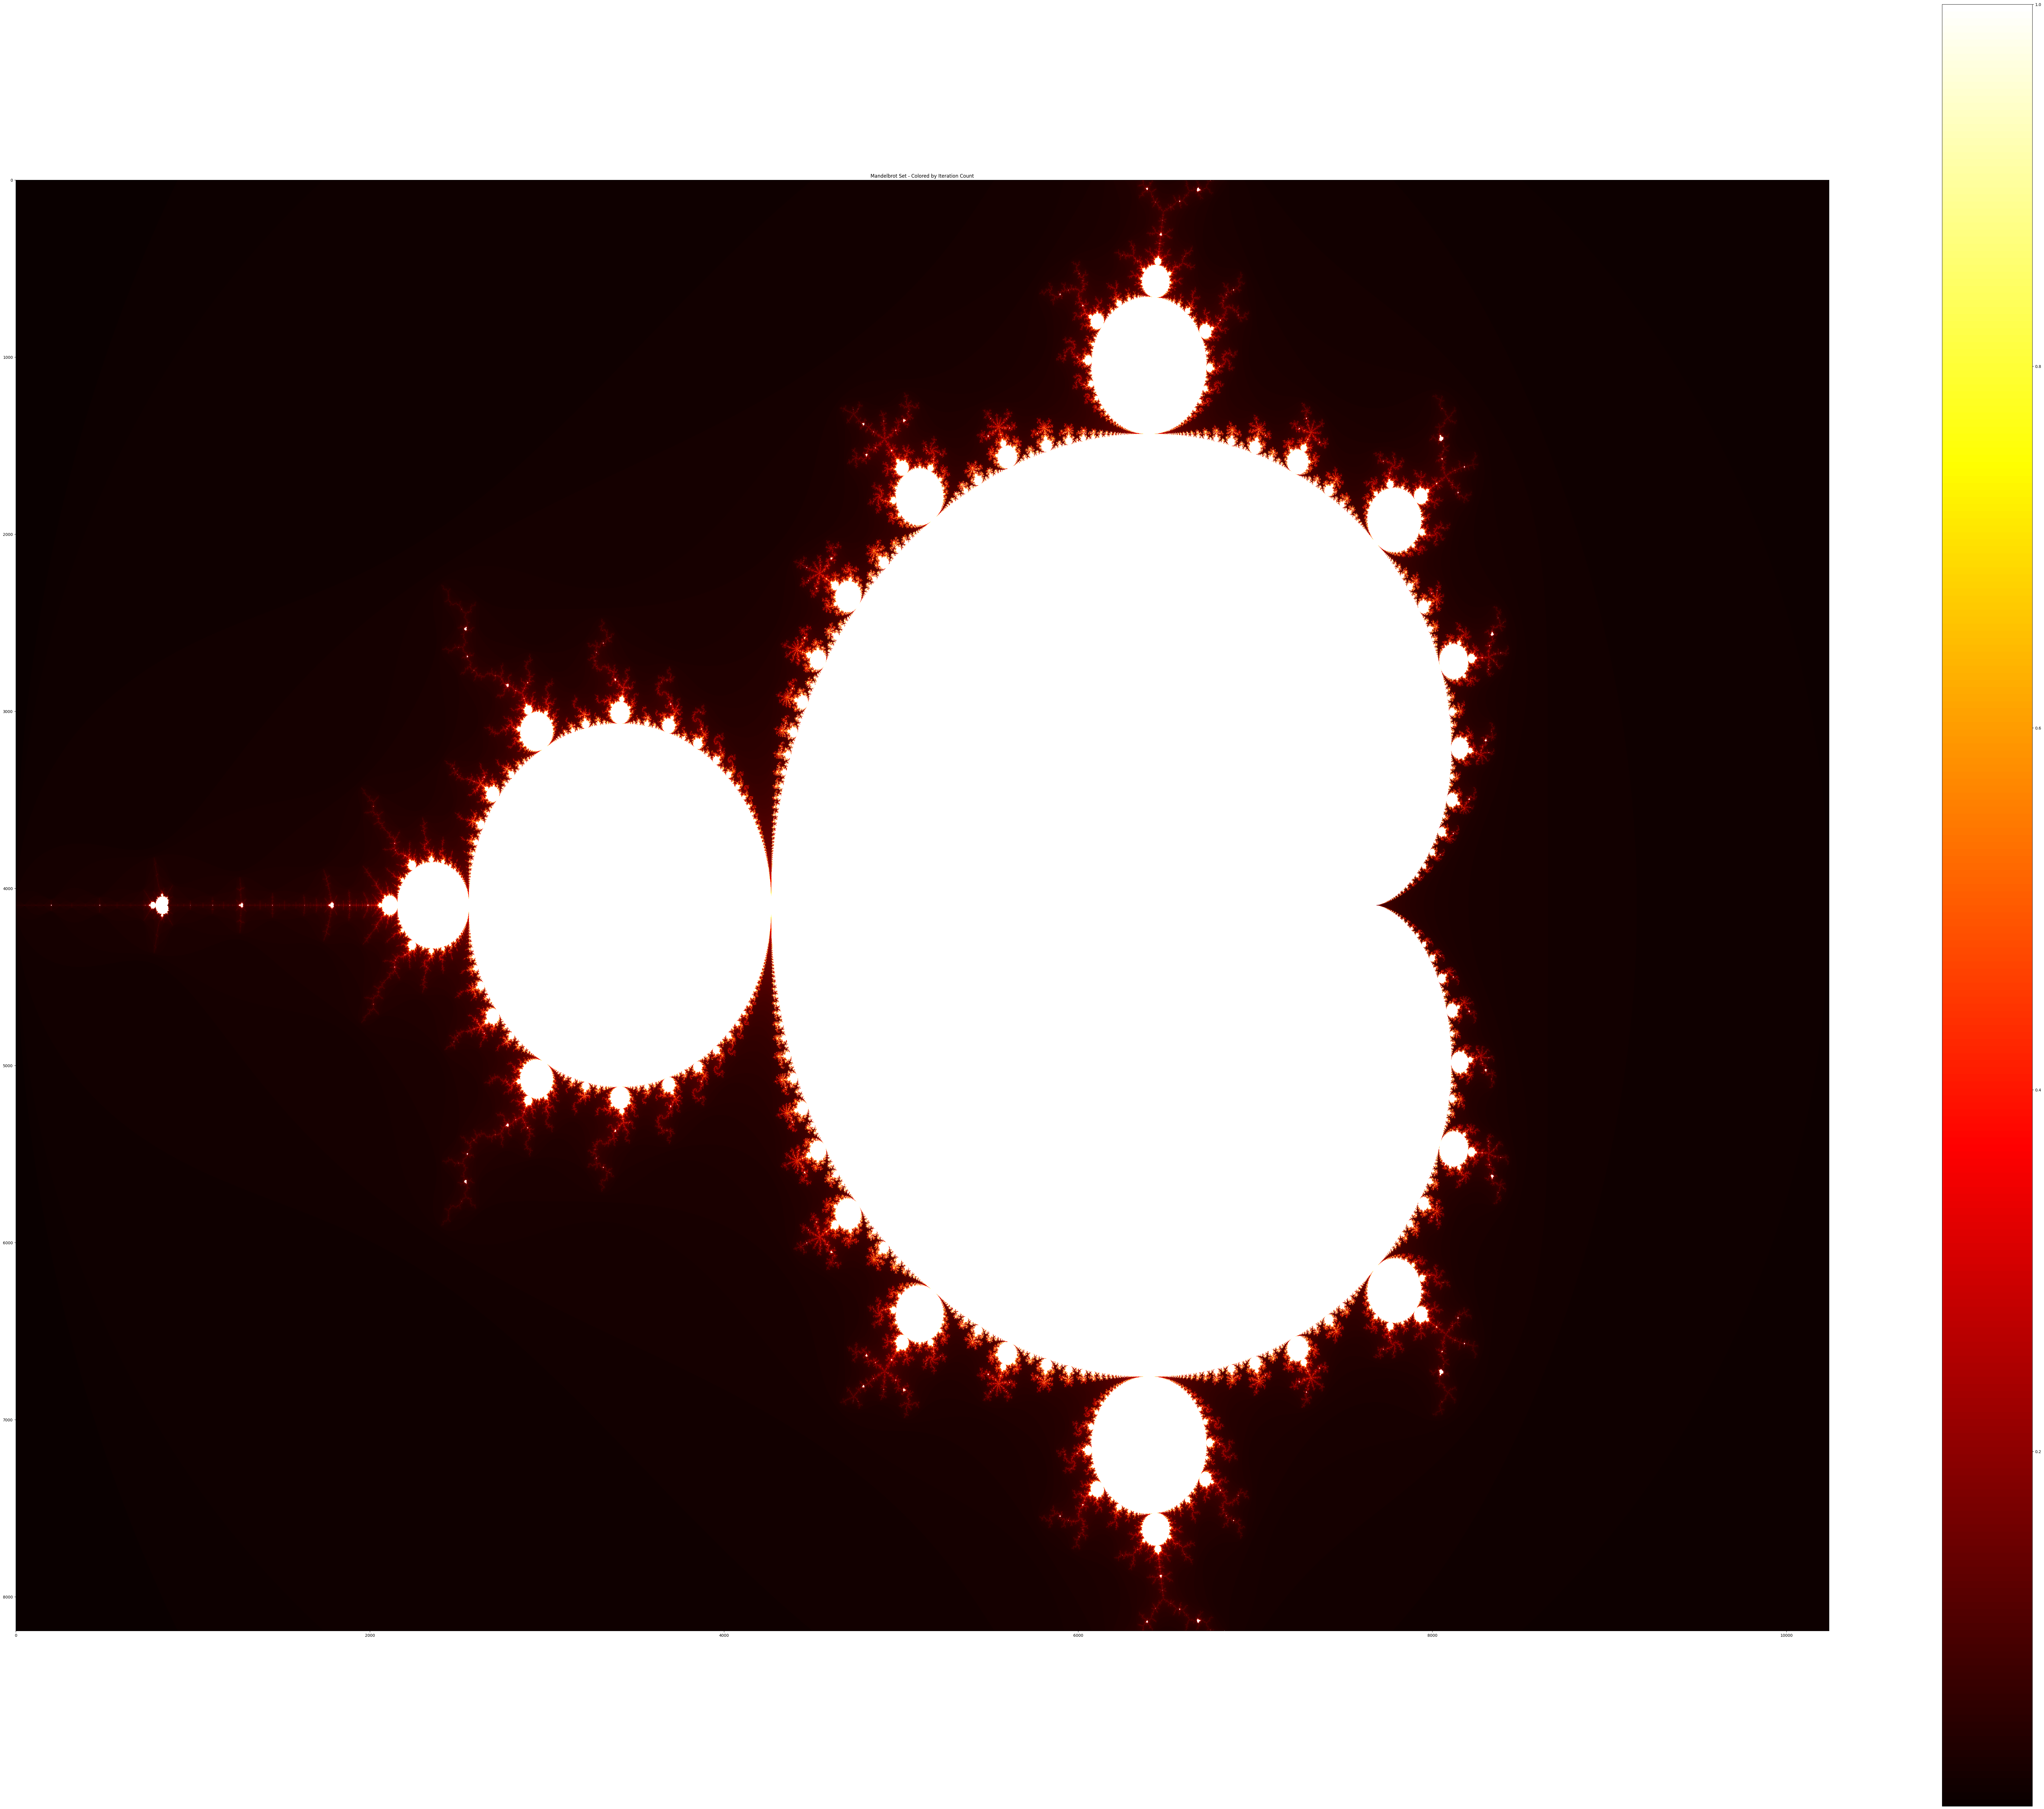

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Image dimensions (same as in CUDA code)
width, height = 1280*8 , 1024*8

# Load the raw output from the CUDA program
counts = np.fromfile('mandelbrot.raw', dtype=np.uint32).reshape((height, width))
normalized_counts = counts/256

# Set a larger figure size (width x height in inches)
plt.figure(figsize=(width/100, height/100))  # Adjust size as needed

# Display the image with a color map
plt.imshow(normalized_counts, cmap='hot', interpolation='none')
plt.colorbar()  # adds a color bar to the side for reference
plt.title("Mandelbrot Set - Colored by Iteration Count")

# Show or save the color-coded image
plt.savefig('/content/mandelbrot_image_colored.png')
plt.show()

# Download the saved image file
#files.download('/content/mandelbrot_image_colored.png')


# New Section